In [120]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EVT 

In [121]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [122]:
def bg_cdf(z: np.ndarray, z_star: float, beta: float, gamma: float) -> np.ndarray:
    return np.exp(-((gamma / beta * (z - z_star)) ** (-1 / gamma)))


def bg_pdf(z: np.ndarray, z_star: float, beta: float, gamma: float):
    return (
        1
        / beta
        * (gamma / beta * (z - z_star)) ** (-1 / gamma - 1)
        * np.exp(-((gamma / beta * (z - z_star)) ** (-1 / gamma)))
    )


def gev_pdf(z: np.ndarray, alpha: float, beta: float, gamma: float):
    return (
        1
        / beta
        * (1 + gamma * (z - alpha) / beta) ** (-1 / gamma - 1)
        * np.exp(-((1 + gamma * (z - alpha) / beta) ** (-1 / gamma)))
    )


# assume gamma < 0
def z_star_from_alpha_beta_gamma(alpha: float, beta: float, gamma: float):
    return alpha - beta / gamma


def alpha_from_z_star_beta_gamma(z_star: float, beta: float, gamma: float):
    return z_star + beta / gamma


# def bg_log_likelihood(z: np.ndarray, z_star: float, beta: float, gamma: float):
#     return -np.sum(np.log(beta) + (1/gamma + 1 ) * np.log(gamma/beta*(z-z_star)) - (gamma/beta*(z-z_star))**(-1/gamma))

# def bg_ll_jac(z: np.ndarray, z_star: float, beta: float, gamma: float):
#     jac = np.zeros([2])
#     # dll/beta
#     jac[0] = -np.sum(1/beta - (1/gamma +1) / (gamma/beta*(z-z_star)) * gamma/beta -(gamma/beta*(z-z_star))**(-1/gamma -1))
#     jac[1] = -np.sum()
#     return jac

# \log\left(\mathcal{L}\left(z; z^{*}, \beta, \gamma\right)\right) & = & - n \log \beta - \left(1+\frac{1}{\gamma}\right)\sum_{i=1}^{n} \log\left(2+\frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right) \\ &&- \sum_{i=1}^{n}\left(2+ \frac{\gamma}{\beta}\left(z_i - z^{*}\right)\right)^{-\frac{1}{\gamma}}.

In [123]:
pdfs = bg_pdf(np.array([1, 2, 3]), 4, 1, -0.5)
pdfs

array([0.15809884, 0.36787944, 0.38940039])

In [124]:
# np.log(pdfs), np.sum(np.log(pdfs)), bg_log_likelihood(np.array([1, 2, 3]), 4, 1, -0.5)

In [125]:
import numpy as np


@np.vectorize
def ll_gamma(gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, 1, gamma)))


@np.vectorize
def ll_beta(beta: float = 1) -> float:
    return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, beta, -0.5)))


@np.vectorize
def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
    return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, beta, gamma)))


@np.vectorize
def ll_alpha_beta_gamma(
    alpha: float = 4, beta: float = 1, gamma: float = -0.5
) -> float:
    return np.sum(np.log(gev_pdf(np.array([1, 2, 3]), alpha, beta, gamma)))

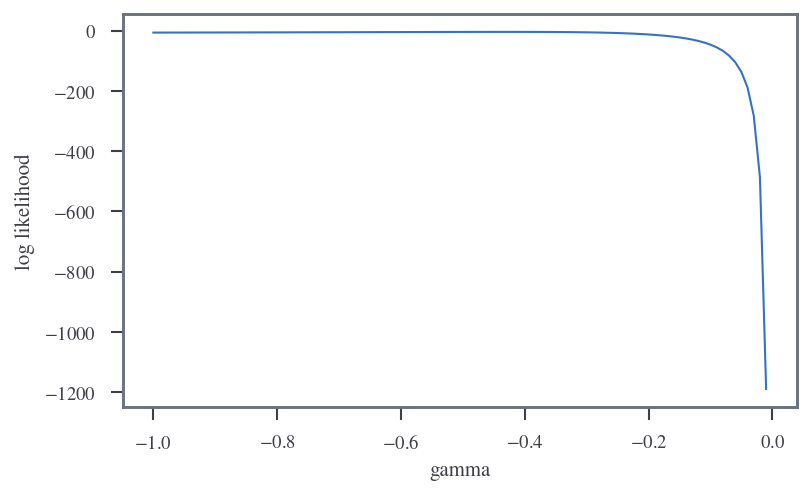

In [126]:
gammas = np.linspace(-1, -0.01, 100)
lls = ll_gamma(gammas)

plt.plot(gammas, lls)
plt.xlabel("gamma")
plt.ylabel("log likelihood")
plt.show()

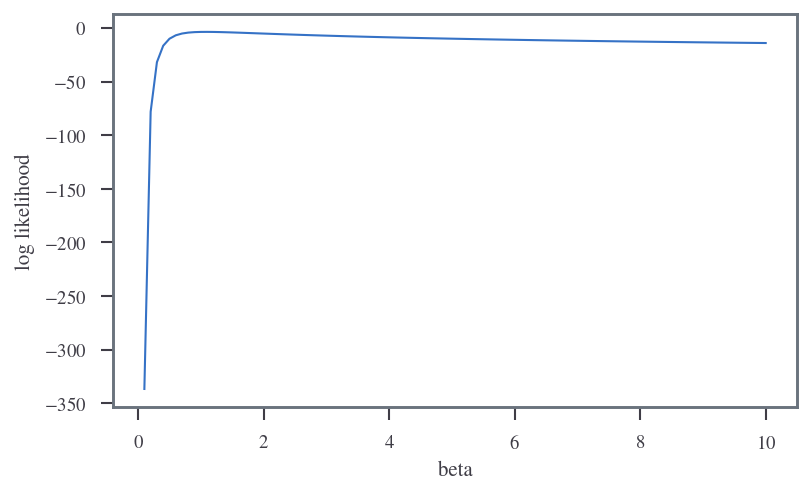

In [127]:
betas = np.linspace(0.1, 10, 100)
lls = ll_beta(betas)
plt.plot(betas, lls)
plt.xlabel("beta")
plt.ylabel("log likelihood")
plt.show()

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/932850866.py:14: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(bg_pdf(np.array([1, 2, 3]), 4, beta, gamma)))


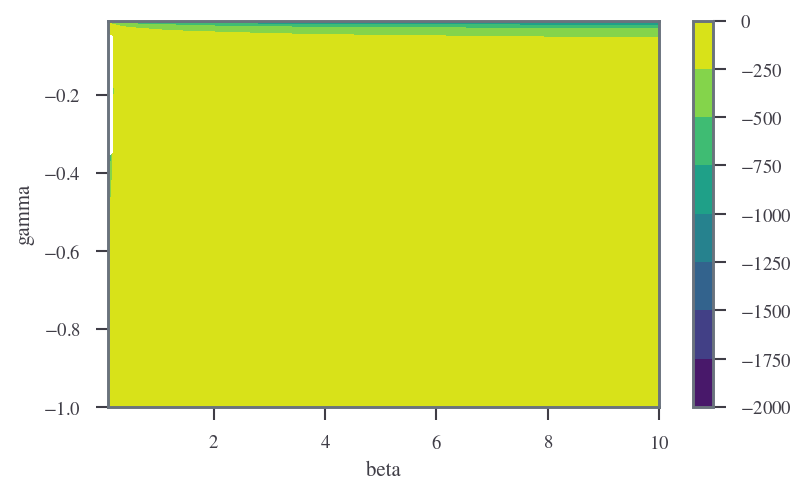

In [128]:
betas = np.linspace(0.1, 10, 100)
gammas = np.linspace(-1, -0.01, 100)
betas, gammas = np.meshgrid(betas, gammas)

lls = ll_beta_gamma(betas, gammas)

plt.contourf(betas, gammas, lls)
plt.xlabel("beta")
plt.ylabel("gamma")
plt.colorbar()

In [129]:
z = np.array([1, 2, 3, 4, 5])
z_star = 6

In [130]:
from scipy.optimize import minimize

In [131]:
mins = minimize(
    lambda x: -ll_beta_gamma(x[0], x[1]),
    x0=[1, -0.5],
    bounds=[(0.01, None), (None, -0.01)],
)

Text(0.5, 0, 'Return Period [years]')

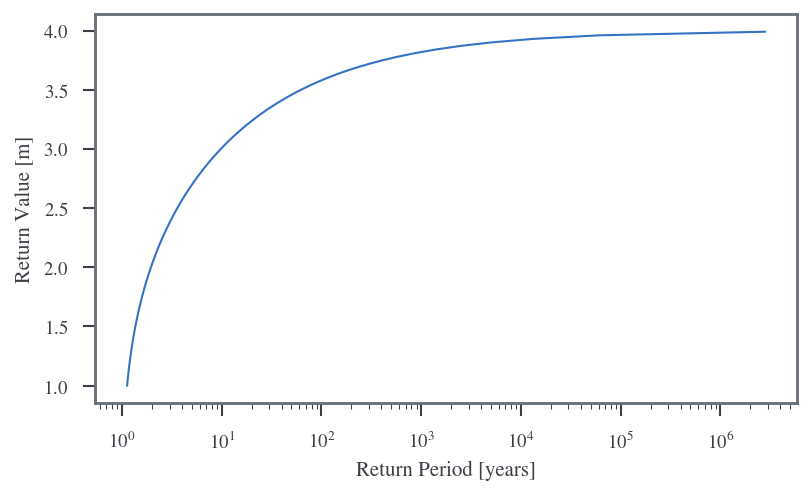

In [132]:
znew = np.linspace(1, 3.99, num=100)
rp = 1 / (1 - bg_cdf(znew, 4, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

Text(0.5, 0, 'Return Period [years]')

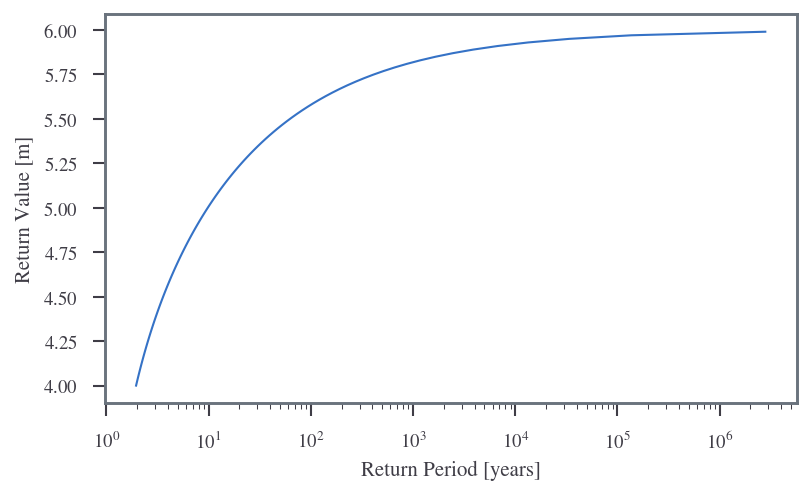

In [133]:
znew = np.linspace(4, 5.99, num=100)

rp = 1 / (1 - bg_cdf(znew, z_star, mins.x[0], mins.x[1]))
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")

In [134]:
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults

plot_defaults()

Text(0.5, 0, 'Return Period [years]')

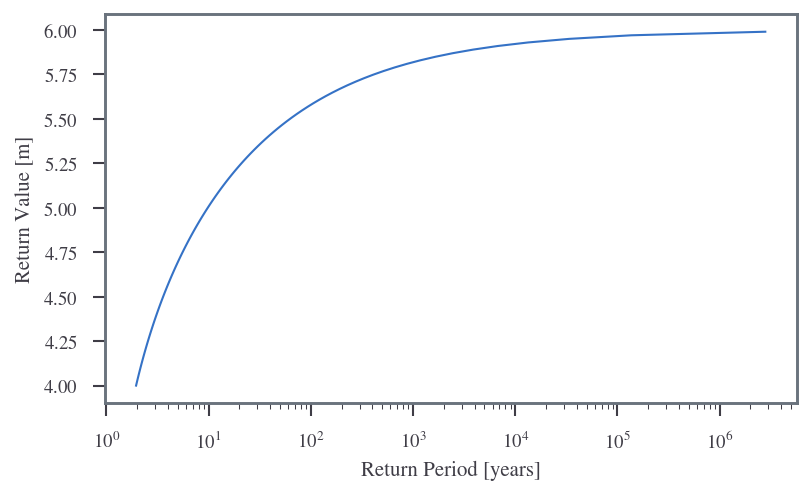

In [135]:
plt.semilogx(rp, znew)
plt.ylabel("Return Value [m]")
plt.xlabel("Return Period [years]")
# plot a horizontal line at z_star

In [136]:
from scipy.stats import genextreme
from typing import Tuple


def gen_samples_from_gev(z_star: float, beta: float, gamma: float, n: int):
    return genextreme.rvs(
        loc=alpha_from_z_star_beta_gamma(z_star, beta, gamma),
        scale=beta,
        c=-gamma,
        size=n,
    )


def return_ll_beta_gamma(z: np.ndarray, z_star: float):
    @np.vectorize
    def ll_beta_gamma(beta: float = 1, gamma: float = -0.5) -> float:
        return np.sum(np.log(bg_pdf(z, z_star, beta, gamma)))

    return ll_beta_gamma


def return_ll_alpha_beta_gamma(z: np.ndarray):
    @np.vectorize
    def ll_alpha_beta_gamma(
        alpha: float = 4, beta: float = 1, gamma: float = -0.5
    ) -> float:
        return np.sum(np.log(gev_pdf(z, alpha, beta, gamma)))

    return ll_alpha_beta_gamma


def min_ll_bg(z: np.ndarray, z_star: float) -> Tuple[float, float]:
    mins = minimize(
        lambda x: -return_ll_beta_gamma(z, z_star)(x[0], x[1]),
        x0=[1, -0.5],
        bounds=[(0.01, None), (None, -0.01)],
    )
    return mins.x[0], mins.x[1]


def min_ll_gev(z: np.ndarray, bounded: bool = True) -> Tuple[float, float, float]:
    if bounded:
        tup = (None, -0.01)
    else:
        tup = (None, None)
    mins = minimize(
        lambda x: -return_ll_alpha_beta_gamma(z)(x[0], x[1], x[2]),
        x0=[4, 1, -0.3],
        bounds=[(None, None), (0.01, None), tup],
        jac="3-point",
        hess="3-point",
    )
    return mins.x[0], mins.x[1], mins.x[2]

In [143]:
from sithom.time import timeit


def plot_rp(alpha: float, beta: float, gamma: float, color: str = "blue", label=""):
    z1yr = genextreme.isf(0.8, c=-gamma, loc=alpha, scale=beta)
    z1myr = genextreme.isf(1 / 1_000_000, c=-gamma, loc=alpha, scale=beta)
    znew = np.linspace(z1yr, z1myr, num=100)

    print(z1yr, z1myr)
    if gamma < 0:  # Weibull class have upper bound
        z_star = z_star_from_alpha_beta_gamma(alpha, beta, gamma)
        plt.hlines(z_star, 2, 1_000_000, color=color, linestyles="dashed")
        rp = 1 / (1 - bg_cdf(znew, z_star, beta, gamma))
    else:
        rp = 1 / genextreme.sf(znew, c=-gamma, loc=alpha, scale=beta)
    plt.semilogx(rp, znew, color=color, label=label, alpha=0.5)
    plt.ylabel("Return Value [m]")
    plt.xlabel("Return Period [years]")


@timeit
def try_fit(
    z_star: float = 7, beta: float = 4, gamma: float = -0.1, n: int = 40
) -> None:
    alpha = alpha_from_z_star_beta_gamma(z_star, beta, gamma)
    zs = gen_samples_from_gev(z_star, beta, gamma, n)
    bg_beta, bg_gamma = min_ll_bg(zs, z_star)
    bg_alpha = alpha_from_z_star_beta_gamma(z_star, bg_beta, bg_gamma)
    f_alpha, f_beta, f_gamma = min_ll_gev(zs)
    u_alpha, u_beta, u_gamma = min_ll_gev(zs, bounded=False)

    f_zstar = z_star_from_alpha_beta_gamma(f_alpha, f_beta, f_gamma)
    u_zstar = z_star_from_alpha_beta_gamma(u_alpha, u_beta, u_gamma)
    print(
        f"True: alpha={alpha}, beta={beta}, gamma={gamma}, z_star={z_star}, 1/100={genextreme.isf(1/100, c=-gamma, loc=alpha, scale=beta)}"
    )
    print(
        f"Max known: alpha={alpha}, beta={bg_beta}, gamma={bg_gamma}, z_star={z_star}, 1/100={genextreme.isf(1/100, c=-bg_gamma, loc=bg_alpha, scale=bg_beta)}"
    )
    print(
        f"Max unknown: alpha={f_alpha}, beta={f_beta}, gamma={f_gamma}, z_star={f_zstar}, 1/100={genextreme.isf(1/100, c=-f_gamma, loc=f_alpha, scale=f_beta)}"
    )
    print(
        f"Unbounded: alpha={u_alpha}, beta={u_beta}, gamma={u_gamma}, zstar={u_zstar}, 1/100={genextreme.isf(1/100, c=-u_gamma, loc=u_alpha, scale=u_beta)}"
    )

    plot_rp(alpha, beta, gamma, color="blue", label="True")
    plot_rp(bg_alpha, bg_beta, bg_gamma, color="purple", label="Max known")
    plot_rp(f_alpha, f_beta, f_gamma, color="red", label="Bounded, max unknown")
    plot_rp(u_alpha, u_beta, u_gamma, color="green", label="Unbounded, max unknown")
    sorted_zs = np.sort(zs)
    empirical_rps = len(zs) / np.arange(1, len(zs) + 1)[::-1]
    plt.scatter(
        empirical_rps,
        sorted_zs,
        s=3,
        alpha=0.8,
        color="black",
        label="Simulated data points",
    )
    plt.legend()


# try_fit(z_star=7, beta=4, gamma=-0.5, n=100)

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/4138574267.py:8: RuntimeWarning: invalid value encountered in power
  return 1/beta * (1 + gamma * (z - alpha)/beta)**(-1/gamma -1) * np.exp(-(1 + gamma * (z - alpha)/beta)**(-1/gamma))
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/3518646072.py:11: RuntimeWarning: divide by zero encountered in divide
  rp = 1 / (1 - bg_cdf(znew, z_star, beta, gamma))


True: alpha=4.5, beta=1, gamma=-0.4, z_star=7, 1/100=6.602980133837946
Max known: alpha=4.5, beta=0.9793829693740305, gamma=-0.39497557395491306, z_star=7, 1/100=6.597011702429443
Max unknown: alpha=4.6761848144126335, beta=1.1073075033708988, gamma=-1.6812390609962466, z_star=5.334810663085662, 1/100=5.3345223749850135
Unbounded: alpha=5.217013877196881, beta=1.067398300228206, gamma=-2.7311883662628333, zstar=5.6078321427597055, 1/100=5.607830776435756
3.975805636170378 6.990047318745626
4.007641792971357 6.98941894550965
3.86889982642193 5.33481066303181
4.174188877959848 5.6078321427597055
'try_fit'  0.07169 s 



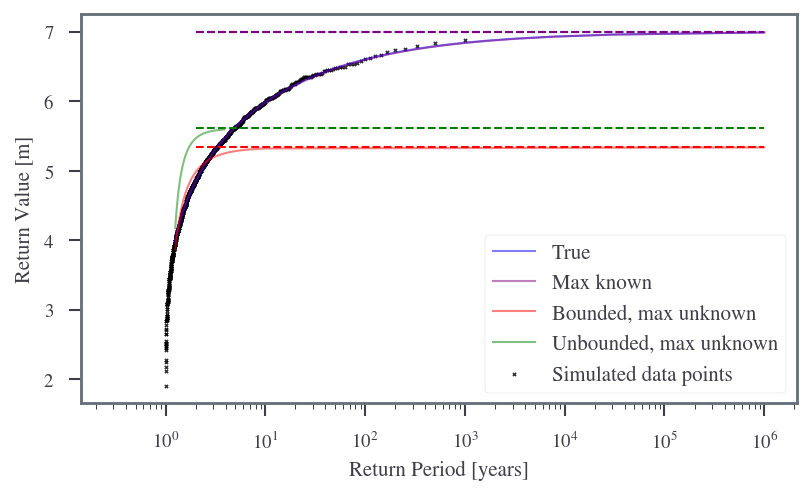

In [144]:
try_fit(z_star=7, beta=1, gamma=-0.4, n=1000)

/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/4138574267.py:8: RuntimeWarning: invalid value encountered in power
  return 1/beta * (1 + gamma * (z - alpha)/beta)**(-1/gamma -1) * np.exp(-(1 + gamma * (z - alpha)/beta)**(-1/gamma))
/var/folders/q5/n7rv_91d6b58cbb5xkzlsc4c0000gn/T/ipykernel_46151/3518646072.py:11: RuntimeWarning: divide by zero encountered in divide
  rp = 1 / (1 - bg_cdf(znew, z_star, beta, gamma))


True: alpha=4.5, beta=1, gamma=-0.4, z_star=7, 1/100=6.602980133837946
Max known: alpha=4.5, beta=1.080025954239566, gamma=-0.41046288580142876, z_star=7, 1/100=6.601774036706079
Max unknown: alpha=9.088054996747065, beta=0.758324805298431, gamma=-7.609608782154179, z_star=9.187708583022989, 1/100=9.187708583022989
Unbounded: alpha=9.430066705165803, beta=0.6273214857230793, gamma=-8.302552360618593, zstar=9.50562437207058, 1/100=9.50562437207058
3.975805636170378 6.990047318745626
3.801160885088726 6.990934681391657
5.462050899858998 9.187708583022989
5.5773470979898505 9.50562437207058
'try_fit'  0.02190 s 



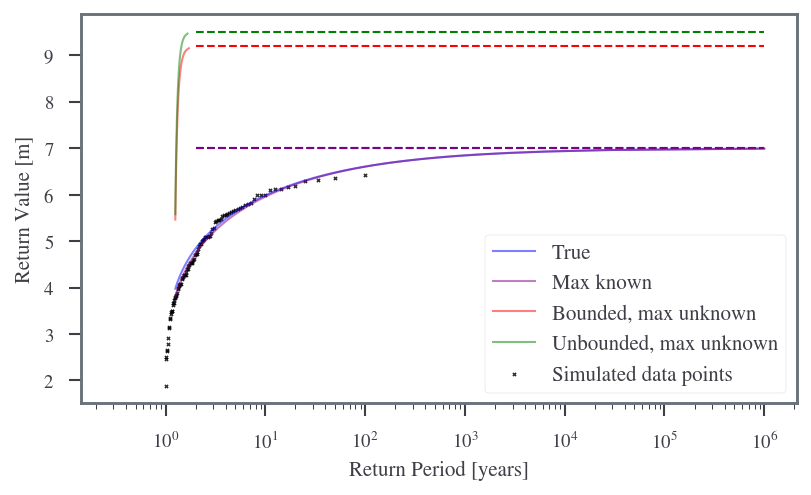

In [145]:
try_fit(z_star=7, beta=1, gamma=-0.4, n=100)